In [9]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, Subset
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler

In [10]:
# device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
# print(f"Using {device} device")

In [50]:
class NeuralNetwork(nn.Module):
    """A vanilla feedforward neutral network."""
    def __init__(self, input_size, hidden_size=25, dropout_rate=0.5):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, 1),
        )

    def forward(self, x):
        output = self.linear_relu_stack(x)
        return output
    
input_size = 200
hidden_size = 30
dropout_rate = 0.1

model = NeuralNetwork(input_size, hidden_size, dropout_rate)

In [51]:
# Custom Dataset for Time Series.
class TimeSeriesDataset(Dataset):
    def __init__(self, data, num_lags):
        """
        data: a 1D numpy array or list of time series values.
        num_lags: the number of previous time steps to use as input features.
        """
        self.data = data
        self.num_lags = num_lags
    
    def __len__(self):
        # Each sample consists of seq_length inputs and 1 target value.
        return len(self.data) - self.num_lags
    
    def __getitem__(self, idx):
        # Input sequence: from idx to idx+seq_length.
        x = self.data[idx:idx+self.num_lags]
        # Target: the value immediately after the input sequence.
        y = self.data[idx+self.num_lags]
        # Reshape x to (num_lags, 1) and y to (1,)
        x = np.array(x, dtype=np.float32).reshape(-1, 1)
        y = np.array([y], dtype=np.float32)
        return torch.tensor(x), torch.tensor(y)
    

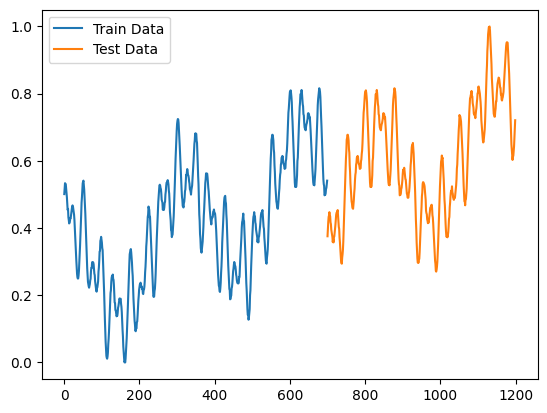

In [52]:
# Create a sine wave time series with some noise
time_steps = 1000
t = np.linspace(0, 50, time_steps)
y = np.sin(3*t) + t/10 + np.cos(5*t) + 2*np.cos(0.4*t) + np.random.normal(0, 0.05, time_steps)

def prescale(data):
    data = data.reshape(-1, 1)
    scaler = MinMaxScaler()
    scaler.fit(data, y=None)
    return scaler.transform(data).reshape(-1)
y = prescale(y)

split = 0.7
train_dataset = TimeSeriesDataset(y[:int(len(y)*split)], num_lags=input_size)
test_dataset = TimeSeriesDataset(y[int(len(y)*split)-input_size:], num_lags=input_size)

plt.plot(range(len(train_dataset.data)), train_dataset.data, label='Train Data')
plt.plot(range(len(train_dataset.data), len(train_dataset.data) + len(test_dataset.data)), test_dataset.data, label='Test Data')
plt.legend()

In [53]:
batch_size = 50
num_epochs = 2000
lr = 0.01
torch.manual_seed(1)

dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Loss and optimizer
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
best_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (x, y) in enumerate(dataloader):
        x = x.reshape(-1, input_size)
        optimizer.zero_grad()     
        pred = model(x)           
        loss = loss_function(pred, y)
        loss.backward()              
        optimizer.step()             
        running_loss += loss.item()
    
    avg_loss = running_loss / len(dataloader)
    if avg_loss < best_loss: 
       torch.save(model.state_dict(), 'best_model.pt')

    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{num_epochs}, Loss: {avg_loss:.4f}")

model.load_state_dict(torch.load("best_model.pt"))

Epoch 0/2000, Loss: 0.0746
Epoch 100/2000, Loss: 0.0015
Epoch 200/2000, Loss: 0.0010
Epoch 300/2000, Loss: 0.0012
Epoch 400/2000, Loss: 0.0011
Epoch 500/2000, Loss: 0.0008
Epoch 600/2000, Loss: 0.0012
Epoch 700/2000, Loss: 0.0015
Epoch 800/2000, Loss: 0.0015
Epoch 900/2000, Loss: 0.0016
Epoch 1000/2000, Loss: 0.0010
Epoch 1100/2000, Loss: 0.0008
Epoch 1200/2000, Loss: 0.0014
Epoch 1300/2000, Loss: 0.0013
Epoch 1400/2000, Loss: 0.0015
Epoch 1500/2000, Loss: 0.0010
Epoch 1600/2000, Loss: 0.0016
Epoch 1700/2000, Loss: 0.0019
Epoch 1800/2000, Loss: 0.0025
Epoch 1900/2000, Loss: 0.0024


<All keys matched successfully>

In [58]:
def plot_predictions(model, dataset):
    y_pred = np.array([])
    y_true = np.array([])

    model.eval()
    with torch.no_grad():
        for idx in range(len(dataset)):
            x, y = dataset[idx]
            output = model(x.reshape(-1, input_size))
            y_pred = np.concatenate((y_pred, output.numpy().flatten()))
            y_true = np.concatenate((y_true, y.numpy().flatten()))
            
    # Plot the predictions and ground-truth values
    plt.figure(figsize=(12, 6))
    plt.plot(y_pred, label='Predictions')
    plt.plot(y_true, 'k--', label='Ground Truth')
    plt.legend()
    plt.show()

def plot_joint_predictions(model, train_dataset, test_dataset):
    #! TBW
    pass

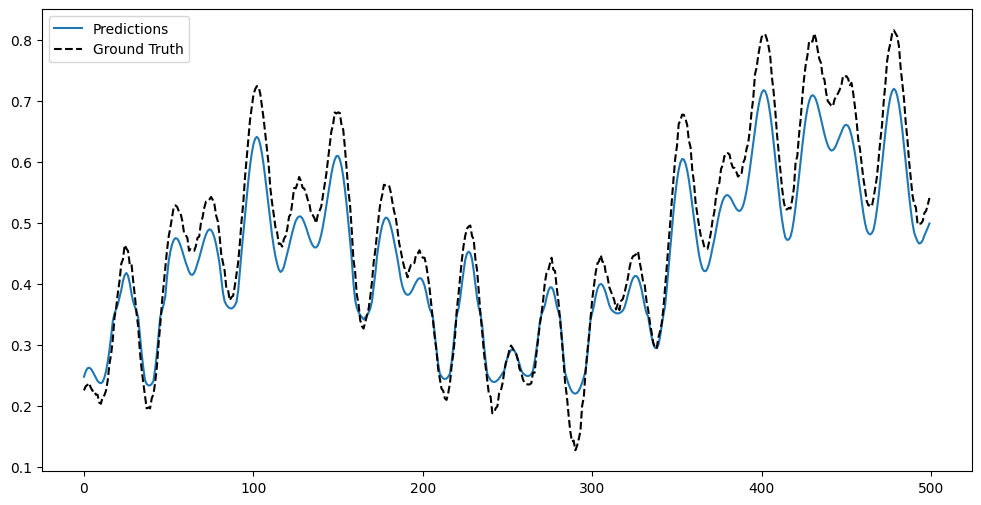

In [59]:
plot_predictions(model, train_dataset)

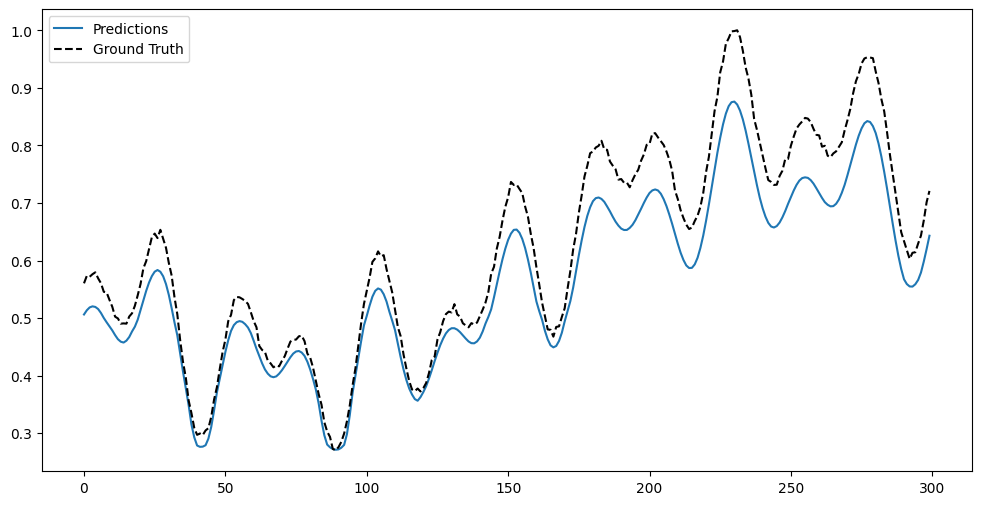

In [60]:
plot_predictions(model, test_dataset)